<a href="https://colab.research.google.com/github/likw99/awesome_colab/blob/main/visual_anagrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Anagrams: Generating Multi-View Optical Illusions with Diffusion Models

<font color='red'>**This colab notebook requires a high RAM and V100 GPU runtime, available through Colab Pro.**</font> (If you figure out how to run this with free tier resources, please make a pull request or let me know!)

This colab notebook generates [visual anagrams and other multi-view optical illusions](https://github.com/dangeng/visual_anagrams). These are images that change appearance or identity when transformed, such as by a rotation or a permutation of pixels. Please visit our [website](https://dangeng.github.io/visual_anagrams/) for more details.

By the way, if you generate a particularly good illusion, please send it our way! We'd love to feature it on our website.

## DeepFloyd Access

Our method uses [DeepFloyd IF](https://huggingface.co/docs/diffusers/api/pipelines/deepfloyd_if), a pixel-based diffusion model. We do not use Stable Diffusion because latent diffusion models cause artifacts in illusions (see our paper for more details).

Before using DeepFloyd IF, you must accept its usage conditions. To do so:

1. Make sure to have a [Hugging Face account](https://huggingface.co/join) and be logged in.
2. Accept the license on the model card of [DeepFloyd/IF-I-XL-v1.0](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0). Accepting the license on the stage I model card will auto accept for the other IF models.
3. Log in locally by running the following cell and entering your [Hugging Face Hub access token](https://huggingface.co/docs/hub/security-tokens#what-are-user-access-tokens), which can be [found here](https://huggingface.co/settings/tokens).

In [ ]:
from huggingface_hub import login
login()

## Install Dependencies

Run the below to install dependencies, including [the `visual_anagrams` repo](https://github.com/dangeng/VisualAnagrams_prerelease) which will do the heavy lifting.

In [ ]:
! pip install -q \
  diffusers \
  transformers \
  safetensors \
  sentencepiece \
  accelerate \
  bitsandbytes \
  einops \
  mediapy

!pip install -q git+https://github.com/dangeng/visual_anagrams.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Import Dependencies and Misc Setup

We import packages we need and define some useful functions

In [ ]:
import mediapy as mp

import torch
from diffusers import DiffusionPipeline

from visual_anagrams.views import get_views
from visual_anagrams.samplers import sample_stage_1, sample_stage_2
from visual_anagrams.utils import add_args, save_illusion, save_metadata

device = 'cuda'

def im_to_np(im):
  im = (im / 2 + 0.5).clamp(0, 1)
  im = im.detach().cpu().permute(1, 2, 0).numpy()
  im = (im * 255).round().astype("uint8")
  return im

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Load Models

This may take a while. We're using the [DeepFloyd IF](https://www.deepfloyd.ai/deepfloyd-if) stage I and stage II models, and they are quite big. (If the below code fails, check that you've followed the instructions at the top of this notebook. You must accept the DeepFloyd IF conditions AND log in to huggingface locally).

In [ ]:
stage_1 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-I-M-v1.0",
                variant="fp16",
                torch_dtype=torch.float16,
              )
stage_1.enable_model_cpu_offload()
stage_1 = stage_1.to(device)

stage_2 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-II-M-v1.0",
                text_encoder=None,
                variant="fp16",
                torch_dtype=torch.float16,
              )
stage_2.enable_model_cpu_offload()
stage_2 = stage_2.to(device)

model_index.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/pytorch_model.fp16-00002-of-00002.bin, text_encoder/pytorch_model.fp16-00001-of-00002.bin, unet/diffusion_pytorch_model.fp16.bin]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.bin, safety_checker/pytorch_model.bin
If this behavior is not expected, please check your folder structure.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

(…)ncoder/pytorch_model.bin.index.fp16.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

pytorch_model.fp16-00002-of-00002.bin:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

pytorch_model.fp16-00001-of-00002.bin:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/743M [00:00<?, ?B/s]

watermarker/config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or

model_index.json:   0%|          | 0.00/692 [00:00<?, ?B/s]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

(…)_noising_scheduler/scheduler_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

watermarker/config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/922M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, image_noising_scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


## Prompts and Views

To generate an illusion, we need to provide a list of views and a corresponding list of prompt embeddings. We start with the list of views, which we can get by passing a list of strings to the `get_views` function. For a list of views and their implementation see the `views.py` file. Views inherit from the `BaseView` class, so you can implement your own views if you want.

### The Art of Choosing Prompts

**Choosing prompts for illusions can be fairly tricky and unintuitive**. Many prompts simply won't make for good illusions, because they are too hard. Here are some tips:

- Styles such as "a photo of" tend to be harder as the constraint of realism is fairly difficult (but this doesn't mean they can't work!).
- Conversely, styles such as "an oil painting of" seem to do better because there's more freedom to how it can be depicted and interpreted.
- In a similar vein, subjects that allow for high degrees of flexibility in depiction tend to be good. For example, prompts such as "houseplants" or "wine and cheese" or "a kitchen"
- But be careful the subject is still easily recognizable. Illusions are much better when they are instantly understandable.
- Faces often make for very good "hidden" subjects. This is probably because the human visual system is particularly adept at picking out faces. For example, "an old man" or "marilyn monroe" tend to be good subjects.
- Perhaps a bit evident, but 3 view and 4 view illusions are considerably more difficult to get to work.
- Intuition and reasoning works less often than you would expect. Prompts that you think would work great often work poorly, and vice versa. So exploration is key.

In [ ]:
# UNCOMMENT ONE OF THESE

views = get_views(['identity', 'rotate_cw'])
#views = get_views(['identity', 'flip'])
#views = get_views(['identity', 'jigsaw'])

Next, we need text prompts. We can specify a list of strings, and pass it into the `encode_prompt` function.

In [ ]:
# Feel free to change me:
prompts = [
      'an oil painting of a snowy mountain village',
      'an oil painting of a horse'
    ]

# Embed prompts using the T5 model
prompt_embeds = [stage_1.encode_prompt(prompt) for prompt in prompts]
prompt_embeds, negative_prompt_embeds = zip(*prompt_embeds)
prompt_embeds = torch.cat(prompt_embeds)
negative_prompt_embeds = torch.cat(negative_prompt_embeds)  # These are just null embeds

## Generate Illusions

Now, we can sample illusions by denoising all views at once. The `sample_stage_1` function does this and generates a $64 \times 64$ image. The `sample_stage_2` function upsamples the resulting image while denoising all views, and generates a $256 \times 256$ image.

100%|██████████| 30/30 [00:02<00:00, 14.97it/s]


,

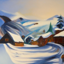
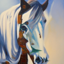

In [ ]:
image_64 = sample_stage_1(stage_1,
                          prompt_embeds,
                          negative_prompt_embeds,
                          views,
                          num_inference_steps=30,
                          guidance_scale=10.0,
                          reduction='mean',
                          generator=None)
mp.show_images([im_to_np(view.view(image_64[0])) for view in views])

100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


,

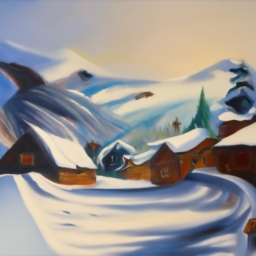
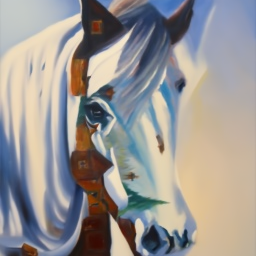

In [ ]:
image = sample_stage_2(stage_2,
                       image_64,
                       prompt_embeds,
                       negative_prompt_embeds,
                       views,
                       num_inference_steps=30,
                       guidance_scale=10.0,
                       reduction='mean',
                       noise_level=50,
                       generator=None)
mp.show_images([im_to_np(view.view(image[0])) for view in views])